In [1]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
wege_gemeinden_geo = pd.read_csv(
    "generated_data/wege_gemeinden_geo.csv", sep=";", encoding="utf-8"
)

FileNotFoundError: [Errno 2] No such file or directory: 'generated_data/wege_gemeinden_geo.csv'

In [39]:
wege_gemeinden_geo.columns

Index(['HHNR', 'Wegnummer', 'Distanz_km', 'Emissionen', 'Verkehrsmittel',
       'Etappennummer', 'Verkehrsmittel_first', 'Zweck', 'Distanz_km_first',
       'Start_X', 'Start_Y', 'Ziel_X', 'Ziel_Y', 'Freizeitaktivität_x',
       'gwp_pro_Kilometer_[g]', 'Emissionen_first', 'WEGNR',
       'Start_X-Koordinate_x', 'Start_Y-Koordinate_x', 'Ziel_X-Koordinate_x',
       'Ziel_Y-Koordinate_x', 'Freizeitaktivität', 'Dauer in Minuten',
       'Wegzweck', 'Alter', 'Geschlecht', 'Führerausweis PW',
       'Führerausweis Motorräder', 'Lernfahrausweis PW',
       'Lernfahrausweis Motorräder', 'Ausbildungsniveau', 'Beschäftigungsgrad',
       'Wetter', 'Velo-Besitzer', 'Mofa-Besitzer', 'Kleinmotorrad-Besitzer',
       'Motorrad-Besitzer', 'Auto-Besitzer', 'Familienstand', 'Erwerbsstatus',
       'Tägliche Freizeitwege', 'Wohnort X-Koordinate', 'Wohnort Y-Koordinate',
       'W_ORT', 'Wohnort: PLZ', 'Wohnort: Kanton', 'Führerausweis_PW',
       'Führerausweis_Motorrad', 'Start_X-Koordinate_y',
    

In [40]:
# Auswahl der relevanten Spalten
features = ["Alter", "Typologie", "Ausbildungsniveau"]
target = "Emissionen"

In [41]:
dummies = pd.get_dummies(
    wege_gemeinden_geo[features],
    drop_first=False,  # Alle Kategorien beibehalten
)

In [42]:
# Festlegen der Referenzkategorien
dummies = dummies.drop(
    ["Alter_81-100", "Typologie_Grosszentren", "Ausbildungsniveau_Keine Schulbildung"],
    axis=1,
)

In [43]:
# Kombinieren der Dummy-Variablen mit der Zielvariable
data = pd.concat([dummies, wege_gemeinden_geo[target]], axis=1)

# Features (X) und Zielvariable (y) definieren
X = data.drop(columns=target)
y = data[target]

# Hinzufügen eines Interzepts zur linearen Regression
X = sm.add_constant(X)

# Erstellen des Modells
model = sm.OLS(y, X)

# Fitting des Modells
results = model.fit()

# Zusammenfassung des Modells anzeigen
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Emissionen   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.090
Date:                Tue, 07 Jan 2025   Prob (F-statistic):           6.17e-13
Time:                        09:51:13   Log-Likelihood:            -6.0259e+05
No. Observations:               55751   AIC:                         1.205e+06
Df Residuals:                   55730   BIC:                         1.205e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [44]:
# Koeffizienten und Konfidenzintervalle aus den Modellresultaten extrahieren
coefficients = results.params
conf_intervals = results.conf_int()

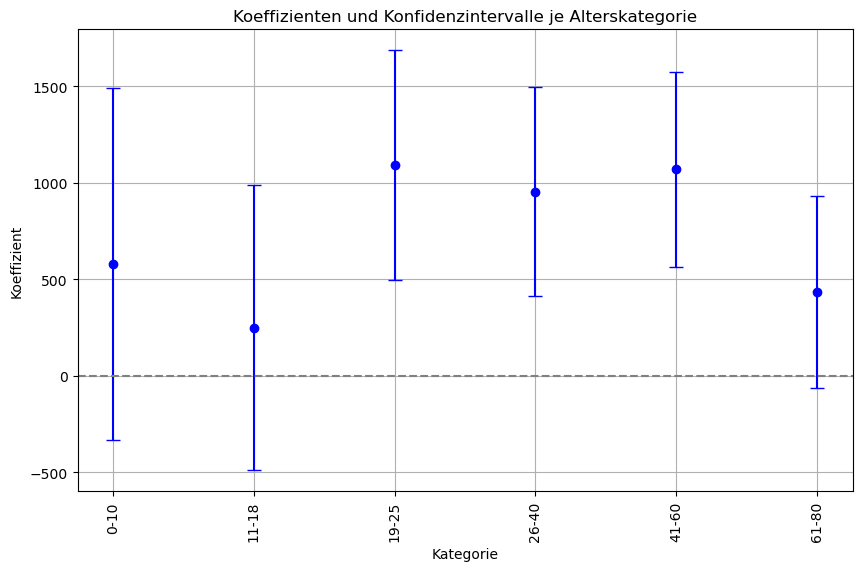

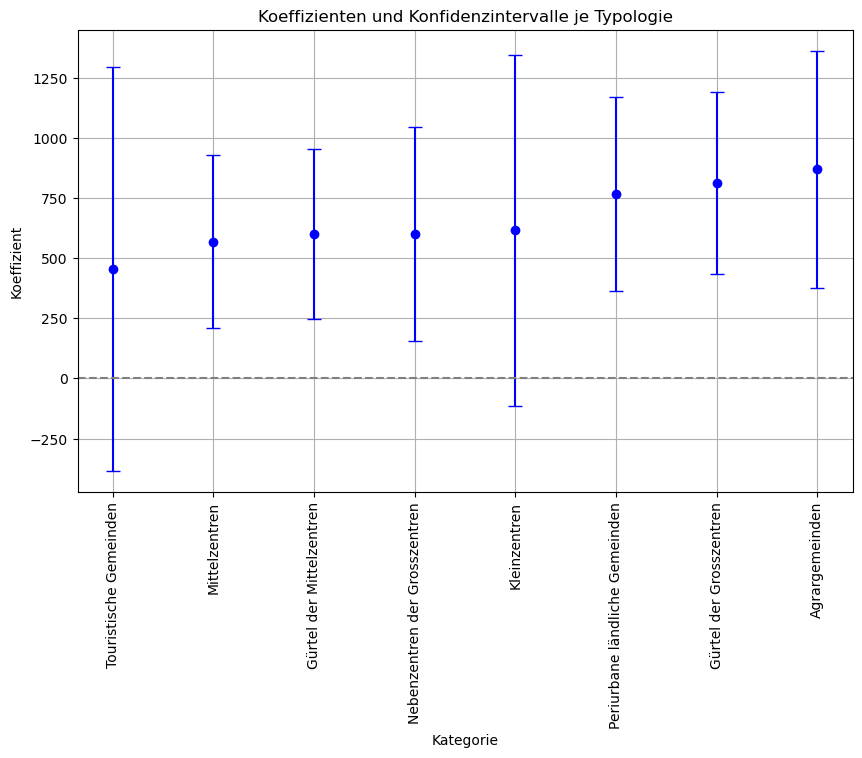

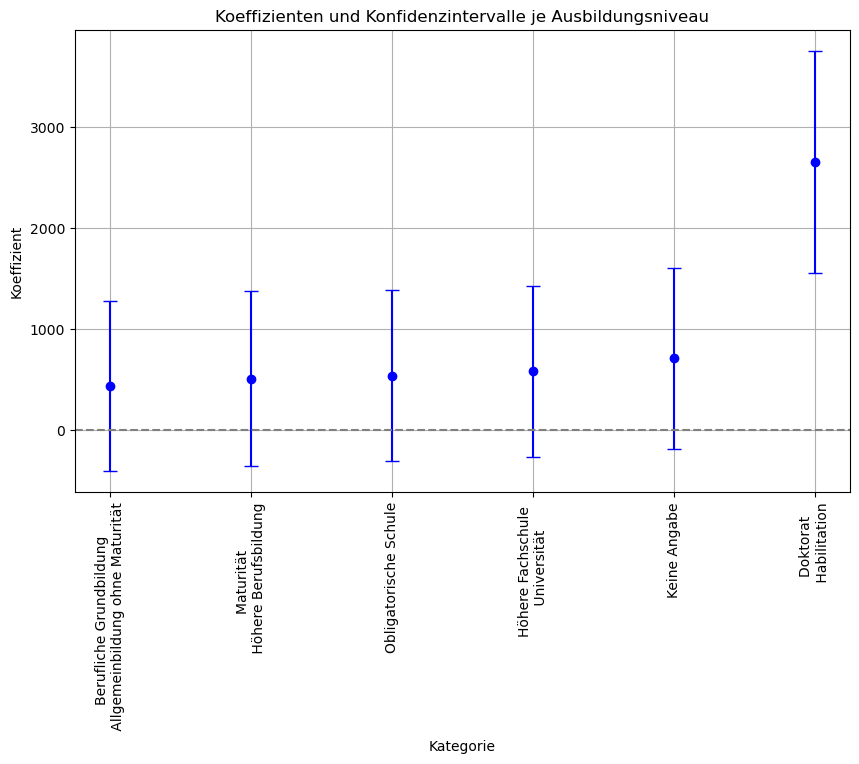

In [ ]:
# Filterfunktion für Kategorien basierend auf einem Präfix und Präfix aus Beschriftungen entfernen
def filter_and_clean_categories(prefix):
    categories = [col for col in coefficients.index if col.startswith(prefix)]
    clean_categories = [col[len(prefix) + 1 :] for col in categories]
    return categories, clean_categories


# Plot-Funktion mit optionaler Sortierung der Koeffizienten
def plot_coefficients_sorted(categories, clean_categories, title, sort=True):
    if sort:
        # Sortieren der Koeffizienten
        sorted_indices = coefficients[categories].sort_values().index
    else:
        sorted_indices = categories

    sorted_coeff = coefficients[sorted_indices]
    sorted_conf_int = conf_intervals.loc[sorted_indices]
    sorted_labels = [
        clean_categories[categories.index(idx)].replace("/", "\n")
        for idx in sorted_indices
    ]

    plt.figure(figsize=(10, 6))
    plt.errorbar(
        sorted_labels,
        sorted_coeff,
        yerr=(sorted_conf_int[1] - sorted_coeff, sorted_coeff - sorted_conf_int[0]),
        fmt="o",
        color="blue",
        capsize=5,
    )
    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel("Kategorie")
    plt.ylabel("Koeffizient")
    plt.title(title)
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.show()


# Alterskategorien plotten (nicht sortiert)
age_categories, age_labels = filter_and_clean_categories("Alter")
plot_coefficients_sorted(
    age_categories,
    age_labels,
    "Koeffizienten und Konfidenzintervalle je Alterskategorie",
    sort=False,
)

# Typologien plotten (sortiert)
typology_categories, typology_labels = filter_and_clean_categories("Typologie")
plot_coefficients_sorted(
    typology_categories,
    typology_labels,
    "Koeffizienten und Konfidenzintervalle je Typologie",
    sort=True,
)

# Ausbildungsniveaus plotten (sortiert)
education_categories, education_labels = filter_and_clean_categories(
    "Ausbildungsniveau"
)
plot_coefficients_sorted(
    education_categories,
    education_labels,
    "Koeffizienten und Konfidenzintervalle je Ausbildungsniveau",
    sort=True,
)